In [1]:
### REGRESION LOGISTICA & REGRESION RIDGE

In [8]:

import numpy as np, pandas as pd
DATA_PATH = "../datasets/final/ico_dataset_final_v2_clean_enriquecido.csv"
#DATA_PATH = "../datasets/final/ico_dataset_final_v2_clean_enriquecido_feature_engineering_v1.csv"
test = pd.read_csv(DATA_PATH)
print(len(test['location'].value_counts()))
print(len(test['category'].value_counts()))
print(len(test['platform'].value_counts()))
print(test['location'].value_counts().head(15))

135
84
17
location
Singapore                   461
United States of America    459
United Kingdom              402
Estonia                     293
Russia                      284
Switzerland                 236
Hong Kong                   146
Germany                     146
USA                         126
United Arab Emirates        123
Australia                   119
Cayman Islands              117
Netherlands                 117
UK                          113
Canada                      106
Name: count, dtype: int64



Métricas (TEST) - Logistic: {'best_params': {'clf__C': 4.6415888336127775, 'clf__class_weight': 'balanced', 'clf__solver': 'lbfgs'}, 'roc_auc': 0.9193121693121693, 'pr_auc': 0.8992655806091234, 'f1': 0.812755519215045, 'accuracy': 0.8288490284005979, 'brier': 0.11445085151120236, 'confusion_matrix': [[612, 144], [85, 497]]}

Métricas (TEST) - Ridge   : {'best_params': {'clf__alpha': 21.54434690031882, 'clf__class_weight': 'balanced'}, 'roc_auc': 0.9135575192276224, 'pr_auc': 0.8923502625382128, 'f1': 0.7895622895622896, 'accuracy': 0.8131539611360239, 'brier': 0.16145957235942662, 'confusion_matrix': [[619, 137], [113, 469]]}

Mejor por PR-AUC: logreg -> 0.8979

Métricas (TEST) calibradas [logreg | isotonic]: {'model': 'logreg_calibrated_isotonic', 'roc_auc': 0.9195655830106002, 'pr_auc': 0.8978662507818276, 'f1': 0.80067283431455, 'accuracy': 0.8228699551569507, 'brier': 0.11333854737196579, 'confusion_matrix': [[625, 131], [106, 476]]}

🎯 Accuracy: 0.8132

Classification Report:
   

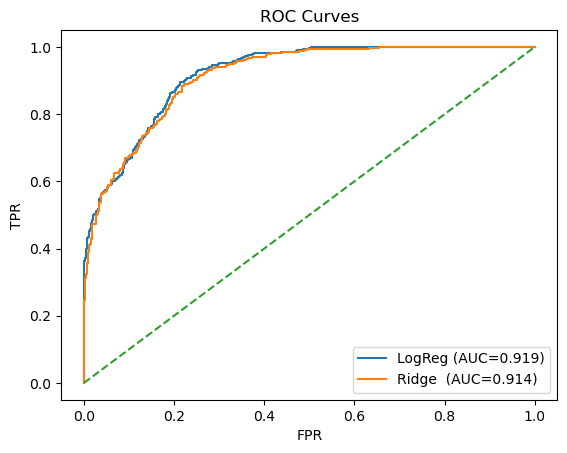

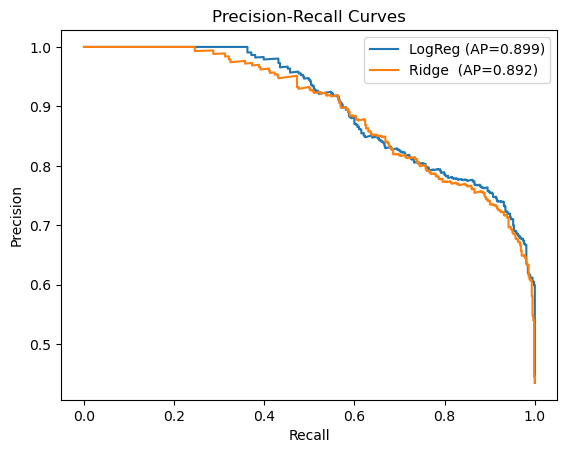

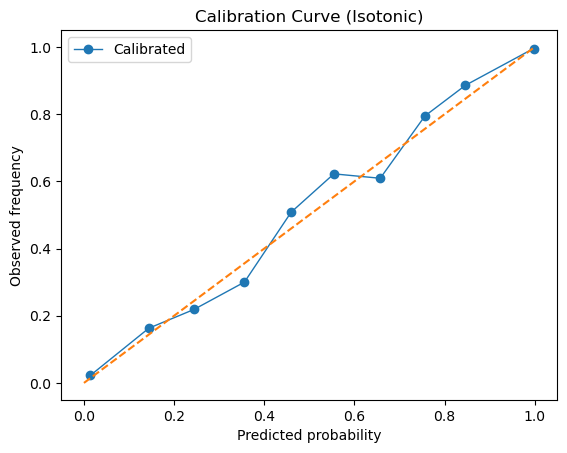

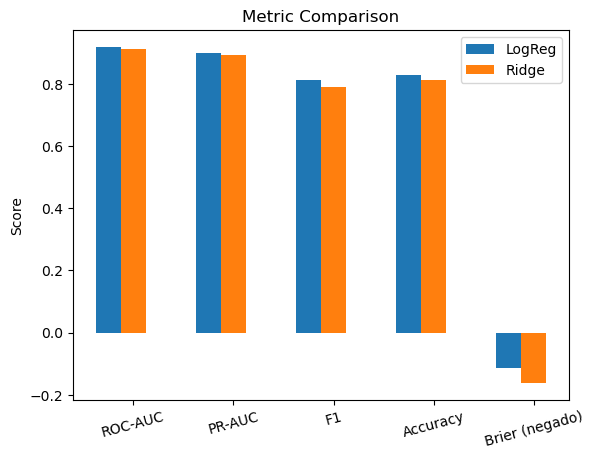

Listo: gráficos en ./experiments/linear_baselines_v1\figs  y artefactos en  ./experiments/ridge_reg_v1
CPU times: total: 1.41 s
Wall time: 1.46 s


In [9]:
%%time

# =======================================
# PREP + LOGISTIC & RIDGE + CALIBRACIÓN #
# + EXPORT DE EXPERIMENTO + GRÁFICOS #
# =======================================
import os, json, time, joblib
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import (
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score,
    f1_score, accuracy_score, brier_score_loss, confusion_matrix, classification_report
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# ---------- Paths
DATA_PATH = "../datasets/final/ico_dataset_final_v2_clean_enriquecido_feature_engineering_preico_v1.csv"
STAMP = time.strftime("%Y%m%d_%H%M%S")
EXP_DIR = f"./experiments/linear_baselines_v1"
FIG_DIR = os.path.join(EXP_DIR, "figs")
os.makedirs(FIG_DIR, exist_ok=True)

# ---------- Cargar Dataset
df = pd.read_csv(DATA_PATH)
target = "ico_successful"
df[target] = df[target].astype(int)
df = df.dropna(subset=[target])

# ---------- Features
cat_candidates = ["platform", "category", "location", "caps_unit"]
bin_candidates = [
    "mvp","has_twitter","has_facebook","is_tax_regulated","has_github",
    "has_reddit","has_website","has_whitepaper","kyc",
    "accepts_BTC","accepts_ETH","has_contract_address"
]
cat_cols = [c for c in cat_candidates if c in df.columns]
bin_cols = [c for c in bin_candidates if c in df.columns]
num_cols = [c for c in df.columns if c not in cat_cols + bin_cols + [target]]

# ---------- Preprocess
num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown="ignore", drop="first"))])
bin_pipe = Pipeline([("imputer", SimpleImputer(strategy="constant", fill_value=0))])
pre = ColumnTransformer([("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols), ("bin", bin_pipe, bin_cols)],
                        remainder="drop", sparse_threshold=0.3)

# ---------- Split
X = df.drop(columns=[target])
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

# ---------- Modelos Lineales
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
logreg_pipe = Pipeline([("pre", pre), ("clf", LogisticRegression(max_iter=2000, penalty="l2", solver="lbfgs"))])
ridge_pipe  = Pipeline([("pre", pre), ("clf", RidgeClassifier(max_iter=2000))])

logreg_grid = {"clf__C": np.logspace(-2, 2, 7), "clf__solver": ["lbfgs", "liblinear"], "clf__class_weight": ["balanced"]}
ridge_grid  = {"clf__alpha": np.logspace(-2, 2, 7), "clf__class_weight": ["balanced"]}

def fit_model(pipe, grid):
    gs = GridSearchCV(pipe, grid, cv=cv, scoring="roc_auc", n_jobs=-1, refit=True)
    gs.fit(X_train, y_train)
    best = gs.best_estimator_
    if hasattr(best.named_steps["clf"], "predict_proba"):
        y_proba = best.predict_proba(X_test)[:, 1]
    else:
        from scipy.special import expit
        y_proba = expit(best.decision_function(X_test))
    y_pred = (y_proba >= 0.5).astype(int)
    mets = {
        "best_params": gs.best_params_,
        "roc_auc": float(roc_auc_score(y_test, y_proba)),
        "pr_auc": float(average_precision_score(y_test, y_proba)),
        "f1": float(f1_score(y_test, y_pred)),
        "accuracy": float(accuracy_score(y_test, y_pred)),
        "brier": float(brier_score_loss(y_test, y_proba)),
        "confusion_matrix": confusion_matrix(y_test, y_pred).tolist()
    }
    return best, y_proba, y_pred, mets

best_log, proba_log, pred_log, m_log = fit_model(logreg_pipe, logreg_grid)
best_rid, proba_rid, pred_rid, m_rid = fit_model(ridge_pipe,  ridge_grid)

print("\nMétricas (TEST) - Logistic:", m_log)
print("\nMétricas (TEST) - Ridge   :", m_rid)


# ---------- Calibración (Isotónica) del mejor por PR-AUC
winner_name = "ridge" if m_rid["pr_auc"] >= m_log["pr_auc"] else "logreg"
winner = best_rid if winner_name == "ridge" else best_log
calibration_method = "isotonic"  # o "sigmoid"
cal = CalibratedClassifierCV(estimator=winner.named_steps["clf"], method=calibration_method, cv=5)
cal_pipe = Pipeline([("pre", pre), ("cal", cal)])
cal_pipe.fit(X_train, y_train)
proba_cal = cal_pipe.predict_proba(X_test)[:, 1]
pred_cal = (proba_cal >= 0.5).astype(int)
m_cal = {
    "model": f"{winner_name}_calibrated_isotonic",
    "roc_auc": float(roc_auc_score(y_test, proba_cal)),
    "pr_auc": float(average_precision_score(y_test, proba_cal)),
    "f1": float(f1_score(y_test, pred_cal)),
    "accuracy": float(accuracy_score(y_test, pred_cal)),
    "brier": float(brier_score_loss(y_test, proba_cal)),
    "confusion_matrix": confusion_matrix(y_test, pred_cal).tolist()
}

print(f"\nMejor por PR-AUC: {winner_name} -> {m_cal['pr_auc']:.4f}")
print(f"\nMétricas (TEST) calibradas [{winner_name} | {calibration_method}]:", m_cal)


# ------------------ EVALUACIÓN ------------------
acc = accuracy_score(y_test, pred_rid)
print(f"\n🎯 Accuracy: {acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, pred_rid, digits=3))

print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_rid))


# ---------- Gráficos
# ROC
fpr_l, tpr_l, _ = roc_curve(y_test, proba_log)
fpr_r, tpr_r, _ = roc_curve(y_test, proba_rid)
#fpr_c, tpr_c, _ = roc_curve(y_test, proba_cal)
plt.figure()
plt.plot(fpr_l, tpr_l, label=f"LogReg (AUC={m_log['roc_auc']:.3f})")
plt.plot(fpr_r, tpr_r, label=f"Ridge  (AUC={m_rid['roc_auc']:.3f})")
#plt.plot(fpr_c, tpr_c, label=f"{winner_name.title()} + Cal (AUC={m_cal['roc_auc']:.3f})")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curves")
plt.legend()
plt.show()
plt.savefig(os.path.join(FIG_DIR, "roc_curves.png"), bbox_inches="tight"); plt.close()

# PR
p_l, r_l, _ = precision_recall_curve(y_test, proba_log)
p_r, r_r, _ = precision_recall_curve(y_test, proba_rid)
#p_c, r_c, _ = precision_recall_curve(y_test, proba_cal)
plt.figure()
plt.plot(r_l, p_l, label=f"LogReg (AP={m_log['pr_auc']:.3f})")
plt.plot(r_r, p_r, label=f"Ridge  (AP={m_rid['pr_auc']:.3f})")
#plt.plot(r_c, p_c, label=f"{winner_name.title()} + Cal (AP={m_cal['pr_auc']:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()
plt.savefig(os.path.join(FIG_DIR, "pr_curves.png"), bbox_inches="tight"); plt.close()

# Calibración
prob_true, prob_pred = calibration_curve(y_test, proba_cal, n_bins=10, strategy="uniform")
plt.figure()
plt.plot(prob_pred, prob_true, marker="o", linewidth=1, label="Calibrated")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration Curve (Isotonic)")
plt.legend()
plt.show()
plt.savefig(os.path.join(FIG_DIR, "calibration_curve.png"), bbox_inches="tight"); plt.close()

# Barras métricas (Brier negado para visualizar “más alto = mejor”)
labels = ["ROC-AUC","PR-AUC","F1","Accuracy","Brier (negado)"]
vals_l = [m_log["roc_auc"], m_log["pr_auc"], m_log["f1"], m_log["accuracy"], -m_log["brier"]]
vals_r = [m_rid["roc_auc"], m_rid["pr_auc"], m_rid["f1"], m_rid["accuracy"], -m_rid["brier"]]
#vals_c = [m_cal["roc_auc"], m_cal["pr_auc"], m_cal["f1"], m_cal["accuracy"], -m_cal["brier"]]
x = np.arange(len(labels)); w = 0.25
plt.figure()
plt.bar(x - w, vals_l, w, label="LogReg")
plt.bar(x,     vals_r, w, label="Ridge")
#plt.bar(x + w, vals_c, w, label=f"{winner_name.title()} + Cal")
plt.xticks(x, labels, rotation=15)
plt.ylabel("Score")
plt.title("Metric Comparison")
plt.legend()
plt.show()
plt.savefig(os.path.join(FIG_DIR, "metrics_bar.png"), bbox_inches="tight"); plt.close()

print("Grabados gráficos en", FIG_DIR)

# ---------- Artefactos
LOGIT_DIR = f"./experiments/logistic_reg_v1"
RIDGE_DIR = f"./experiments/ridge_reg_v1"
os.makedirs(LOGIT_DIR, exist_ok=True)
os.makedirs(RIDGE_DIR, exist_ok=True)

preds = pd.DataFrame({"y_true": y_test.values, "proba_logreg": proba_log})
preds.to_csv(os.path.join(LOGIT_DIR, "test_predictions.csv"), index=False)
with open(os.path.join(LOGIT_DIR, "metrics.json"), "w") as f:
    json.dump({"logreg": m_log}, f, indent=2)
joblib.dump(best_log, os.path.join(LOGIT_DIR, "best_logreg.pkl"))

preds = pd.DataFrame({"y_true": y_test.values, "proba_ridge": proba_rid, f"proba_{winner_name}_cal": proba_cal})
preds.to_csv(os.path.join(RIDGE_DIR, "test_predictions.csv"), index=False)
with open(os.path.join(RIDGE_DIR, "metrics.json"), "w") as f:
    json.dump({"ridge": m_rid, "calibrated": m_cal}, f, indent=2)
joblib.dump(best_rid, os.path.join(RIDGE_DIR, "best_ridge.pkl"))
joblib.dump(cal_pipe, os.path.join(RIDGE_DIR, f"{winner_name}_isotonic_calibrated.pkl"))

print("Grabados artefactos en ", RIDGE_DIR)


In [3]:
##### Importancia de columnas

In [4]:

import numpy as np

def feature_names_from_preprocessor(pre, X):
    names = []
    for name, trans, cols in pre.transformers_:
        if name == "remainder":
            continue
        if hasattr(trans, "named_steps") and "ohe" in trans.named_steps:
            ohe = trans.named_steps["ohe"]
            ohe_names = ohe.get_feature_names_out(cols).tolist()
            names.extend(ohe_names)
        else:
            # num/bin pipes sin OHE
            if isinstance(cols, list):
                names.extend(cols)
            else:
                names.extend(X.columns[cols].tolist())
    return names

# Obtener coeficientes del ganador (Ridge)
pre = winner.named_steps["pre"]
clf = winner.named_steps["clf"]
feat_names = feature_names_from_preprocessor(pre, X_train)

coefs = clf.coef_.ravel()
top_pos_idx = np.argsort(coefs)[-15:][::-1]
top_neg_idx = np.argsort(coefs)[:15]

top_pos = [(feat_names[i], float(coefs[i])) for i in top_pos_idx]
top_neg = [(feat_names[i], float(coefs[i])) for i in top_neg_idx]

print("Top señales a favor (coef +):")
for k,v in top_pos: print(f"{k:40s} {v: .4f}")
print("\nTop señales en contra (coef -):")
for k,v in top_neg: print(f"{k:40s} {v: .4f}")


Top señales a favor (coef +):
hit_soft_cap                              5.6529
has_whitepaper                            3.1708
has_website                               3.0586
platform_Waves                            1.4543
platform_Tron                             1.2828
ico_score                                 0.6230
platform_Stellar                          0.5882
has_twitter                               0.3479
start_year                                0.3399
location_USA                              0.3274
accepts_BTC                               0.2745
has_github                                0.2518
platform_Other                            0.2191
location_United Kingdom                   0.2004
start_qtr                                 0.1371

Top señales en contra (coef -):
is_tax_regulated                         -2.5236
category_Gambling                        -0.7369
category_Platform                        -0.6843
category_Entertainment                   -0.6792
locati